# CMPT 423/820 
## Assignment 2 Question 3
* Seyedeh Mina Mousavifar
* 11279515
* sem311

In [16]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

# add the correct header from wine dataset
header = ['label'] + load_wine()['feature_names'] 
    

# reading dataset and adding header
wine = pd.read_csv('data/a2q3.csv', 
                   header=None, 
                   names=header)

# separating labels
labels = wine.values[:, 0]
data = wine.values[:, 1:]

# Set aside  data as a part of test set
tpropn = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=tpropn)


K_FOLD = 10

# creating answer
models_info = {'KNN': None, 
              'NB': None, 
              'DT': None}

### Part 1.

K-Nearest Neighbours Classifier. Remember that you’ll have to choose K.

> I divided data into the training set and test set and then applied cross-validation on the training set to tune K hyperparameter. However, I realized that due to the small size of our data, the best K with the highest f1-score is highly relying on the division between test set and training set.

> We optimize K by choosing maximum f1-score for different ranges of K. Futher, we calculate f1-score for each K based on the average of 10-fold cross validation. An approach to select range of K is set $K = \sqrt{n}$ based on this [article](https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/). 

#### Finding best K

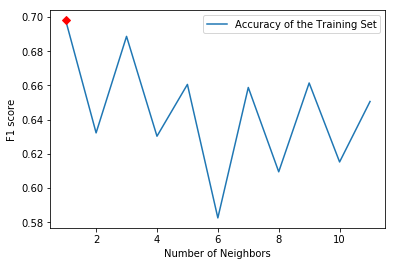

Maximum F1 score is for k = 1 with score of 0.6981403781403783 .


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import math
import matplotlib.pyplot as plt


def knn_classifier(k_in, data_in, label_in):
    """
    :purpose: This function creates an KNN classifier and calculates 
    its training and test accuracy.
    :param k_in: number of nearest neighbors
    :param data_in: training dataset
    :param label_in: true answers for the training dataset
    :return: the f1-score of the model on training set
    """
    
     # creating the KNN classifier
    clf_knn = KNeighborsClassifier(n_neighbors=k_in)
    
    # cross validation 
    train_result = cross_val_score(clf_knn, data_in, 
                                   label_in, cv=K_FOLD, 
                                   scoring='f1_macro')
    
    # return mean of f1 score
    return train_result.mean()


# saving accuracy for different K
training_accuracy = list()

# range of K for knn
k_range = round(math.sqrt(X_train.shape[0]))
neighbors_settings = range(1, k_range)

for n_neighbors in neighbors_settings:
    result = knn_classifier(n_neighbors, 
                           X_train, Y_train)
    
    training_accuracy.append(result)
    

# plotting result
plt.plot(neighbors_settings, training_accuracy,
         label='Accuracy of the Training Set')

# highlighting maximum point
max_point = max(training_accuracy)
max_k = training_accuracy.index(max_point) + 1
plt.plot(max_k, max_point, 'rD')
plt.ylabel('F1 score')
plt.xlabel('Number of Neighbors')
plt.legend()
plt.show()

print('Maximum F1 score is for k =', max_k, 'with score of', max_point, '.')

#### 1-Nearest Neighbours Classifier

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def f1_acc_evaluator(model_in, data_in, label_in):
    """
    :purpose: This function calculated given model
    f1-score and accuracy, based on data
    :param model_in: given model for evaluation
    :param data_in: test dataset
    :param label_in: true answers for the test set
    :return f1_out: the f1-score of the model on test set
    :return acc_out: the accuracy of the model on test set
    """
    
    y_predicted = model_in.predict(data_in)
    
    f1_out = f1_score(label_in,
                      y_predicted,
                      average='macro')
    
    acc_out = accuracy_score(label_in,
                      y_predicted)
    
    return f1_out, acc_out

# creating the KNN classifier
model = KNeighborsClassifier(n_neighbors=max_k)
model.fit(X_train, Y_train) 

# f1 score and accuracy
result, acc = f1_acc_evaluator(model,
                              X_test, Y_test)


# saving answer
models_info['KNN'] = {'f1': round(result, 5),
                      'acc': round(acc, 5)}

# printing result in tabular format
print('\033[1m' + 'KNN classifier for K=1' + '\033[0m')
print('{:<15} {:<15}'.format('F1-score',
                            'Accuracy'))

print('{:<15} {:<15}'.format(models_info['KNN']['f1'], 
                            models_info['KNN']['acc']))

KNN classifier for K=1
F1-score        Accuracy       
0.69842         0.69444        


### Part 2.

Naive Bayes Classifier.

In [38]:
from sklearn.naive_bayes import GaussianNB

# creating the NB classifier
model = GaussianNB()
model.fit(X_train, Y_train)

# f1 score and accuracy
result, acc = f1_acc_evaluator(clf_nb,
                              X_test, Y_test)

# saving answer
models_info['NB'] = {'f1': round(result, 5),
                      'acc': round(acc, 5)}

# printing result in tabular format
print('\033[1m' + 'Naive Bayes classifier' + '\033[0m')
print('{:<15} {:<15}'.format('F1-score',
                            'Accuracy'))

print('{:<15} {:<15}'.format(models_info['NB']['f1'], 
                            models_info['NB']['acc']))

Naive Bayes classifier
F1-score        Accuracy       
0.97087         0.97222        


### Part 3.
Decision Tree Classifier.

> I divided data into the training set and test set and then applied cross-validation on the training set to tune depth hyperparameter. However, I realized that due to the small size of our data, the best depth with the highest f1-score is highly relying on the division between test set and training set. Moreover, the larger the depth will be, we will be more prone to overfitting our data.

> We should set max depth for the classifier to stop it from over fitting. In Scikit Learn [documentation](https://scikit-learn.org/stable/modules/tree.html#tree), it is recommended to start with 3 depth and increase it as needed. The maximum depth can be *N-1* which isn't rational computationally. However the default value is Best. In this model nodes are expanded until all leaves are pure. So we explore different values of depth and pick the one with maximum f1-score in cross validation.

#### Finding appropriate depth

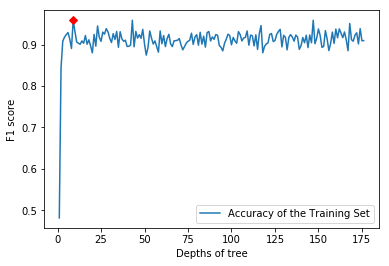

Maximum F1 score is for k = 9 with score of 0.9587826987826986 .


In [40]:
from sklearn import tree

def dt_classifier(d_in, data_in, label_in):
    """
    :purpose: This function creates an Decision tree classifier
    and calculates its training and test accuracy.
    :param d_in: depth of tree
    :param data_in: training dataset
    :param label_in: true answers for the training dataset
    :return: the accuracy of the model on training set
    """
    
     # creating the KNN classifier
    clf_dt = tree.DecisionTreeClassifier(max_depth=d_in)
    
    # cross validation 
    train_result = cross_val_score(clf_dt, data_in, 
                                   label_in, cv=K_FOLD, 
                                   scoring='f1_macro')
    
    # return mean of f1 score
    return train_result.mean()

# saving accuracy for different K
training_accuracy = list()

# range of K for dt
depths = range(1, len(data)-1)

for d in depths:
    result = dt_classifier(d, X_train, Y_train)
    training_accuracy.append(result)
    
# plotting result
plt.plot(depths, training_accuracy,
         label='Accuracy of the Training Set')

# highlighting maximum point
max_point = max(training_accuracy)
max_k = training_accuracy.index(max_point) + 1
plt.plot(max_k, max_point, 'rD')
plt.ylabel('F1 score')
plt.xlabel('Depths of tree')
plt.legend()
plt.show()

print('Maximum F1 score is for k =', max_k, 'with score of', max_point, '.')

#### Decision Tree Classifier

In [41]:
model = tree.DecisionTreeClassifier(max_depth=max_k)
model.fit(X_train, Y_train)

# f1 score and accuracy
result, acc = f1_acc_evaluator(model,
                              X_test, Y_test)


# saving answer
models_info['DT'] = {'f1': round(result, 5),
                      'acc': round(acc, 5)}

# printing result in tabular format
print('\033[1m' + 'Decision Tree classifier' + '\033[0m')
print('{:<15} {:<15}'.format('F1-score',
                            'Accuracy'))

print('{:<15} {:<15}'.format(models_info['DT']['f1'], 
                            models_info['DT']['acc']))

Decision Tree classifier
F1-score        Accuracy       
0.86271         0.86111        


### Comparison

In [43]:
# printing result in tabular format
print('\033[1m' + 'Classifiers Summary' + '\033[0m')
print('{:<20} {:<15} {:<15}'.format('Classifier',
                                    'F1-score',
                                    'Accuracy'))

print('{:<20} {:<15} {:<15}'.format('K Nearest Neighbors',
                                    models_info['KNN']['f1'], 
                                    models_info['KNN']['acc']))

print('{:<20} {:<15} {:<15}'.format('Naive Bayes',
                                    models_info['NB']['f1'], 
                                    models_info['NB']['acc']))

print('{:<20} {:<15} {:<15}'.format('Decision Tree',
                                    models_info['DT']['f1'], 
                                    models_info['DT']['acc']))

Classifiers Summary
Classifier           F1-score        Accuracy       
K Nearest Neighbors  0.69842         0.69444        
Naive Bayes          0.97087         0.97222        
Decision Tree        0.86271         0.86111        


Discuss the performance of the three classifiers. Which, if any, would you choose as the best model for
the data?
> As we can see, *Naive Bayes* have the most f1-score, Accuracy, and the least standard deviation so it performs the best. After that, *Decision Tree* has the second best performance because of f1-score and Accuracy, and *K Nearest Neighbors* has the worst. So I would pick the *Naive Bayes* classifier.

> In the following part, I'll assess different situation, in which each model would work better.
> * *Naive Bayes* is a linear classifier while *K-NN* is not; It tends to be faster when applied to big data. In comparison, *K-NN* is usually slower for large amounts of data, because of the calculations required for each new step in the process. Moreover, this method is not affected by the curse of dimensionality and large feature sets, while *K-NN* has problems with both.
> * Conditional independence will highly negative affect classification, so *K-NN* would be better than *Naive Bayes*. *Naive Bayes* can suffer from the zero probability problem; when a particular attribute's conditional probability equals zero, *Naive Bayes* will completely fail to produce a valid prediction. 
> * *K-NN* and *Naive Bayes* outperform *decision trees* when it comes to rare occurrences. *Decision tree* will almost certainty prune the rare but important classes, out of the model.
> * *Decision trees* have easy to use features to identify the most significant dimensions, handle missing values, and deal with outliers. *Decision trees* work best for a small number of classes.

#### Checking Variability in data

Accuracy is a good measure when the target variable classes in the data are nearly balanced. F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall and there is an uneven class distribution (large number of Actual Negatives). So I will assess our data for the following characteristic.

In [45]:
wine_info = wine.groupby(['label']).size().reset_index(name='count')

total = wine_info['count'].sum()
wine_info['percent'] = round(wine_info['count']*100/total, 2)
wine_info

,label,count,percent
0,1,59,33.15
1,2,71,39.89
2,3,48,26.97


So we can see that both f1-score and accuracy would measure performance appropriately.